In [9]:
import numpy as np
import matplotlib.pyplot as plt

from spectroscopy import N_avo, hplanck, kboltz, c_light, epsilon_0
from spectroscopy import u_mas, m_oxygen, I_co2, B_co2, Delta_F, p0, T0, Ts, Tt
from spectroscopy import wavenum_to_hertz, hertz_to_wavenum, terahertz_to_wavenum
from spectroscopy import normal_mode_2, planck_spec_irradiance
from spectroscopy import T_spec, p_spec, nS, nu_a, nu_THz_a
from spectroscopy import nu_minA, nu_maxA, sig_minA, sig_maxA
from spectroscopy import nu_minB, nu_maxB, sig_minB, sig_maxB

# plot settings
%matplotlib inline
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (10.0, 4.0)

Define various functions:

In [10]:
def create_triangle_spectrum(nu,nu0,sigma_cen,w):
    sigma = sigma_cen*np.exp(-abs(nu-nu0)/w)
    return sigma

In [11]:
def get_S_and_nu_analytic_fn(branch_type,T,B_Hz,nu0_vib_Hz):

    # we only include even J numbers b/c of O nucleus zero spin (Levine p. 288; Goody & Yung p. 88)
    J = np.linspace(2,100,50) # J numbers []
    E_J = hplanck*B_Hz*J*(J+1) # energy [J]
    
    # c.f. Herzberg (I,14) p. 19; G&Y p. 90 eqn. (3.37)
    if branch_type=='P':
        nu_L = -2*B_Hz*(J+1) + nu0_vib_Hz
    elif branch_type=='R':
        nu_L = +2*B_Hz*(J+1) + nu0_vib_Hz
    elif branch_type=='Q':
        nu_L = +2*B_Hz*(J+1)/1e6 + nu0_vib_Hz
        # spacing in Q-branch is purely for numerical purposes
        
    # rotational partition function (Bernath eqn. 6.42)
    Qrot = kboltz*T/(hplanck*B_Hz*2) 
    NJ_div_N = (2*J+1)*np.exp(-E_J/(kboltz*T))/Qrot # occupancy factor [] (Bernath eqn. 6.41)
    S_L = c_light**2*A_mn*NJ_div_N/(8*np.pi*nu_L**2) # line strength [m2 Hz molecule^-1]
    # this is from Bernath eqn. 1.58, using lambda = c/nu and sigma = S*g(nu-nu_{nm})

    return nu_L, S_L

In [12]:
def create_analytic_branch(nu_a,T,ptot,nu_L,S_L):
    
    "Calculates the absorption cross-section per molecule of absorbing gas for a single branch using analytic approach."
    
    # line truncation width [Hz]
    dnu_trunc = wavenum_to_hertz(25.0) 
    
    # line broadening width [Hz]
    gamma_L = (T0/T)**n_broad*gamma_0*(ptot/p0)

    # cross-section array [m2 molecule^-1]
    sigma_a = np.zeros(len(nu_a)) 

    # Lorentzian line profile function [Hz^-1]
    f_Lorentz_fn = lambda nu,nu0 : (abs(nu-nu0)<dnu_trunc)*(1/np.pi)*gamma_L/((nu-nu0)**2 + gamma_L**2)

    # calculate sigma_a [m2 molecule^-1]
    for l in range(len(S_L)):
        line_profile = f_Lorentz_fn(nu_a,nu_L[l])
        sigma_a += line_profile*S_L[l]

    return sigma_a

In [13]:
def create_analytic_band(nu_a,T,ptot,nu0_vib_Hz):
    
    "Combines the analytic absorption cross-sections for P, Q and R branches."

    nu_L, S_L = get_S_and_nu_analytic_fn('P',T,B_co2,nu0_vib_Hz)
    sigmaP_a  = create_analytic_branch(nu_a,T,ptot,nu_L,S_L)

    nu_L, S_L = get_S_and_nu_analytic_fn('Q',T,B_co2,nu0_vib_Hz)
    sigmaQ_a  = create_analytic_branch(nu_a,T,ptot,nu_L,S_L)

    nu_L, S_L = get_S_and_nu_analytic_fn('R',T,B_co2,nu0_vib_Hz)
    sigmaR_a  = create_analytic_branch(nu_a,T,ptot,nu_L,S_L)
    
    sigma_a = sigmaP_a + sigmaQ_a + sigmaR_a

    return sigma_a

In [14]:
def create_analytic_spectrum(nu_a,T,ptot,nu0_vib_Hz,Fermi_delta,nFermi):
    
    "Combines the analytic absorption cross-sections for each vib-rot band."

    # cross-section array [m2 molecule^-1]
    sigma_a = np.zeros(len(nu_a)) 
    
    # calculate sigma_a [m2 molecule^-1]
    for nF in range(0,nFermi):        
        sigma_a += occ_factor**nF*create_analytic_band(nu_a,T,ptot,nu0_vib_Hz-nF*Delta_F/2)
        sigma_a += occ_factor**nF*create_analytic_band(nu_a,T,ptot,nu0_vib_Hz+nF*Delta_F/2)

    return sigma_a

In [15]:
def display_results(sigma_a,PlotA):

    "Displays fundamental band or full band structure, depending on choice of boolean variable PlotA."
    
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(nu_THz_a,sigma_a,color='gray')

    if (not PlotA):
        ax1.plot(nu_THz_a,sigma_tri,color='red',linewidth=3,linestyle='dashed',label='sorted')
    
    ax1.set_yscale('log')
    ax1.axis([nu_minA,nu_maxA,sig_minA,sig_maxA])

    text_y_loc = 4e2/N_avo
    if (not PlotA):
        ax1.text(20.05, text_y_loc/2, 'A',fontsize=12)
        ax1.text(20.05 - (Delta_F/2)/1e12, text_y_loc*occ_factor,    'B',fontsize=12)
        ax1.text(20.05 + (Delta_F/2)/1e12, text_y_loc*occ_factor,    'C',fontsize=12)
        ax1.text(20.05 -  Delta_F/1e12,    text_y_loc*occ_factor**2, 'D',fontsize=12)
        ax1.text(20.05 +  Delta_F/1e12,    text_y_loc*occ_factor**2, 'E',fontsize=12)

    ax1.set_xlabel('frequency [THz]')
    ax1.set_ylabel('$\sigma$ [m$^2$ molelcule$^{-1}$]')

    secax1 = ax1.secondary_xaxis('top', functions=(terahertz_to_wavenum, terahertz_to_wavenum))
    secax1.set_xlabel('wavenumber [cm$^{-1}$]')

    ax2.plot(nu_THz_a,sigma_a,color='gray')
    ax2.set_yscale('log')
    ax2.axis([nu_minB,nu_maxB,sig_minB,sig_maxB])
    xticks_2 = np.linspace(19,21,5)
    ax2.set_xticks(xticks_2)
    ax2.set_xticklabels(xticks_2)
    ax2.set_xlabel('frequency [THz]')
    ax2.set_ylabel('$\sigma$ [m$^2$ molecule$^{-1}$]')
    ax2.text(19.5, 2e2/N_avo, 'P',fontsize=12)
    ax2.text(20.04,2e2/N_avo, 'Q',fontsize=12)
    ax2.text(20.5, 2e2/N_avo, 'R',fontsize=12)

    secax2 = ax2.secondary_xaxis('top', functions=(terahertz_to_wavenum, terahertz_to_wavenum))
    secax2.set_xlabel('wavenumber [cm$^{-1}$]')

    plt.tight_layout()

    # Save the results
    if PlotA:
        plt.savefig('../figures/analytic_CO2_spectrum_A.pdf', format='pdf', dpi=300, bbox_inches='tight')
    else:
        plt.savefig('../figures/analytic_CO2_spectrum_B.pdf', format='pdf', dpi=300, bbox_inches='tight')

Define constants:

In [16]:
nu0_vib_Hz = normal_mode_2() # band center [Hz]
sig_c      = 0.44*(1e-9)**2 # intermolecular collision cross-section [m^2 molecule^-1]
mu_avg     = 28.97*u_mas # mean molecular mass of atmosphere [kg molecule^-1]
A_mn       = 1.0 # estimated Einstein coefficient [s^-1]
occ_factor = np.exp(-hplanck*nu0_vib_Hz/(kboltz*T_spec)) # ground state occupancy factor [] 

print('Delta_F =',round(Delta_F/1e12,2),' THz')
print('Delta_F =',round(hertz_to_wavenum(Delta_F),2),' cm^-1')
print('B =',round(B_co2/1e9,2),'GHz')
print('B =',round(hertz_to_wavenum(B_co2),2),'cm^-1') # matches Herzberg p. 21
print('occ_factor =',round(occ_factor,2),'[]')

Delta_F = 3.07  THz
Delta_F = 102.32  cm^-1
B = 11.74 GHz
B = 0.39 cm^-1
occ_factor = 0.04 []


Calculate line broadening coefficients:

In [17]:
v_av  = np.sqrt(3*kboltz*T0/mu_avg)
v_rel = np.sqrt(2)*v_av
l_mfp = kboltz*T0/(np.sqrt(2)*sig_c*p0)

gamma_0 = v_rel/(2*np.pi*l_mfp)
print('gamma_0 =',round(gamma_0/(1e9),2),'GHz')

gamma_0 = sig_c*p0*np.sqrt(3/(mu_avg*kboltz*T0))/np.pi
print('gamma_0 =',round(gamma_0/(1e9),2),'GHz')

print('gamma_0 =',round(hertz_to_wavenum(gamma_0),2),'cm^-1')

n_broad = 0.5

gamma_0 = 1.75 GHz
gamma_0 = 1.75 GHz
gamma_0 = 0.06 cm^-1


Calculate triangle spectrum for plot:

In [18]:
# band structure coefficient [Hz]
w = lambda T: (Delta_F/2)*kboltz*T/(hplanck*nu0_vib_Hz) 

print('Delta_F = ',round(Delta_F/1e12,2),'THz')
print('Delta_F = ',round(hertz_to_wavenum(Delta_F),2),'cm^-1')
print('w = ',round(w(T0)/1e12,2),'THz')
print('w = ',round(hertz_to_wavenum(w(T0)),2),'cm^-1')
print('y-axis factor = ',round(kboltz*T_spec/(hplanck*nu0_vib_Hz),2),'[]')

# absorption cross-section at band center (arbitrary) [m2 molecule^-1]
sigma_cen = 1.5e1/N_avo 

# create triangle spectrum absorption cross-section [m2 molecule^-1]
sigma_tri = create_triangle_spectrum(nu_a,nu0_vib_Hz,sigma_cen,w(T0))

Delta_F =  3.07 THz
Delta_F =  102.32 cm^-1
w =  0.46 THz
w =  15.35 cm^-1
y-axis factor =  0.3 []


Create full spectrum for plot and display it:

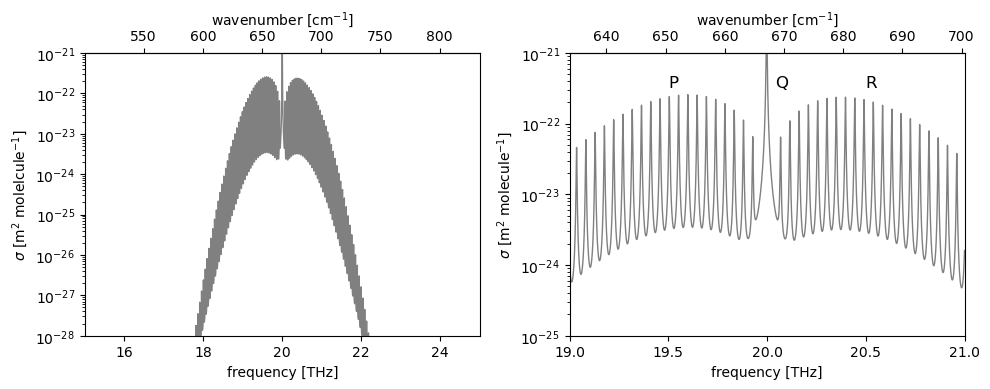

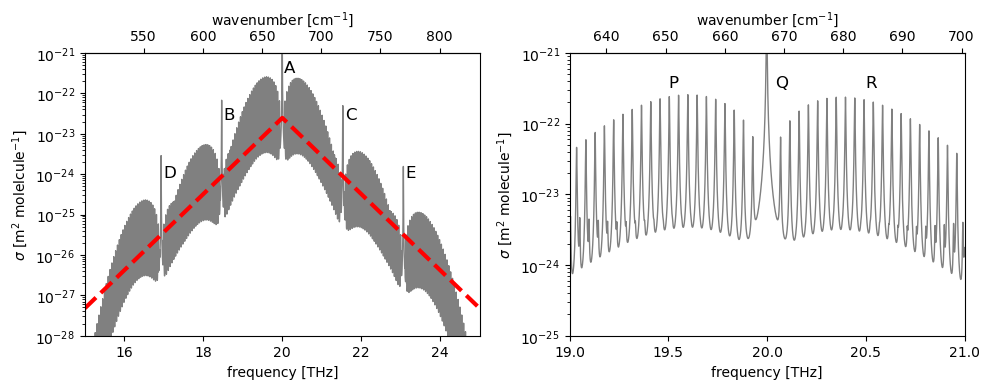

In [19]:
# fundamental band only
sigma_a = create_analytic_spectrum(nu_a,T_spec,p_spec,nu0_vib_Hz,(Delta_F/2),1)
display_results(sigma_a,True)

# band of bands
sigma_a = create_analytic_spectrum(nu_a,T_spec,p_spec,nu0_vib_Hz,(Delta_F/2),3)
display_results(sigma_a,False)

Finally, calculate CO2 radiative forcing:

In [20]:
Bs = planck_spec_irradiance(nu0_vib_Hz,Ts)
Bt = planck_spec_irradiance(nu0_vib_Hz,Tt)

alpha = 2*np.pi*w(250)*(Bs - Bt)
F_2x = alpha*np.log(2)

print('alpha = ',round(alpha,2),'W m^-2')
print('F_2x = ',round(F_2x,2),'W m^-2')

F_2x = np.pi*np.log(2)*kboltz*250*Delta_F*(Bs - Bt)/(hplanck*nu0_vib_Hz)

print('F_2x = ',round(F_2x,2),'W m^-2')

alpha =  7.39 W m^-2
F_2x =  5.12 W m^-2
F_2x =  5.12 W m^-2
